# Single Star - Photometric Observables

This notebook shows how you can use the `SingleStarModel` to infer stellar parameters with photometric observables in Gaia bands and metallicity.

Firstly, import packages.

In [1]:
import numpy as np
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(10)
numpyro.enable_x64()

Then, import the `SingleStarModel` from `celestify`.

In [2]:
from celestify.numpyro_models import SingleStarModel

2023-11-29 14:18:00.032424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 14:18:00.032454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 14:18:00.033422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 14:18:00.611168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [3]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook

rng, key = random.split(rng)
bands = ["BP", "RP", "G"]
true_model = SingleStarModel(bands=bands)

# This samples from the true model given some random key
true_trace = handlers.trace(
    handlers.seed(true_model, key)
).get_trace()
truths = {key: param["value"] for key, param in true_trace.items()}
pprint(truths)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


2023-11-29 14:18:01.499165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


{'Av': Array(1.42788137, dtype=float64),
 'M_H': Array(0.02101892, dtype=float64),
 'R': Array(1.42515131, dtype=float64),
 'Teff': Array(5988.18447427, dtype=float64),
 'Y': Array(0.2546344, dtype=float64),
 'a_MLT': Array(2.26334169, dtype=float64),
 'abs_mag': Array([5.52573336, 4.19877   , 4.92707791], dtype=float64),
 'age': Array(7.80599796, dtype=float64),
 'bol_mag': Array(3.82100664, dtype=float64),
 'distance': Array(980.63770062, dtype=float64),
 'evol': Array(0.18145536, dtype=float64),
 'log_Dnu': Array(1.91783832, dtype=float64),
 'log_L': Array(0.37159734, dtype=float64),
 'log_R': Array(0.15386098, dtype=float64),
 'log_Teff': Array(3.77729517, dtype=float64),
 'log_age': Array(0.89242843, dtype=float64),
 'log_g': Array(4.15960901, dtype=float64),
 'log_mass': Array(0.02926331, dtype=float64),
 'mag': Array([15.48327629, 14.15631293, 14.88462084], dtype=float64),
 'mass': Array(1.06970324, dtype=float64),
 'plx': Array(0.00101974, dtype=float64)}


## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [4]:
rng, *keys = random.split(rng, 3)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(keys[0])  # add noise to metallicity prior

sigma_av = 0.01
mu_av = truths["Av"] + sigma_av * random.normal(keys[1])  # add noise to extinction prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "mag": dict(scale=1e-2),
    "plx": dict(scale=1e-5),
    "Av": dict(loc=mu_av, scale=sigma_av),
}

# Create model
model = SingleStarModel(bands=bands, const=const)

pprint(model.const)  # check all constants

{'Av': {'loc': Array(1.42860046, dtype=float64), 'scale': 0.01},
 'M_H': {'loc': Array(0.0344218, dtype=float64), 'scale': 0.1},
 'distance': {'concentration': 3.0, 'rate': 0.001},
 'dof': 10,
 'evol': {'concentration0': 5.0, 'concentration1': 2.0},
 'log_mass': {'loc': 0.0, 'scale': 0.3},
 'mag': {'scale': 0.01},
 'plx': {'scale': 1e-05}}


## Prior Predictive

Sample from the model prior.

In [5]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=2000)
prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [6]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

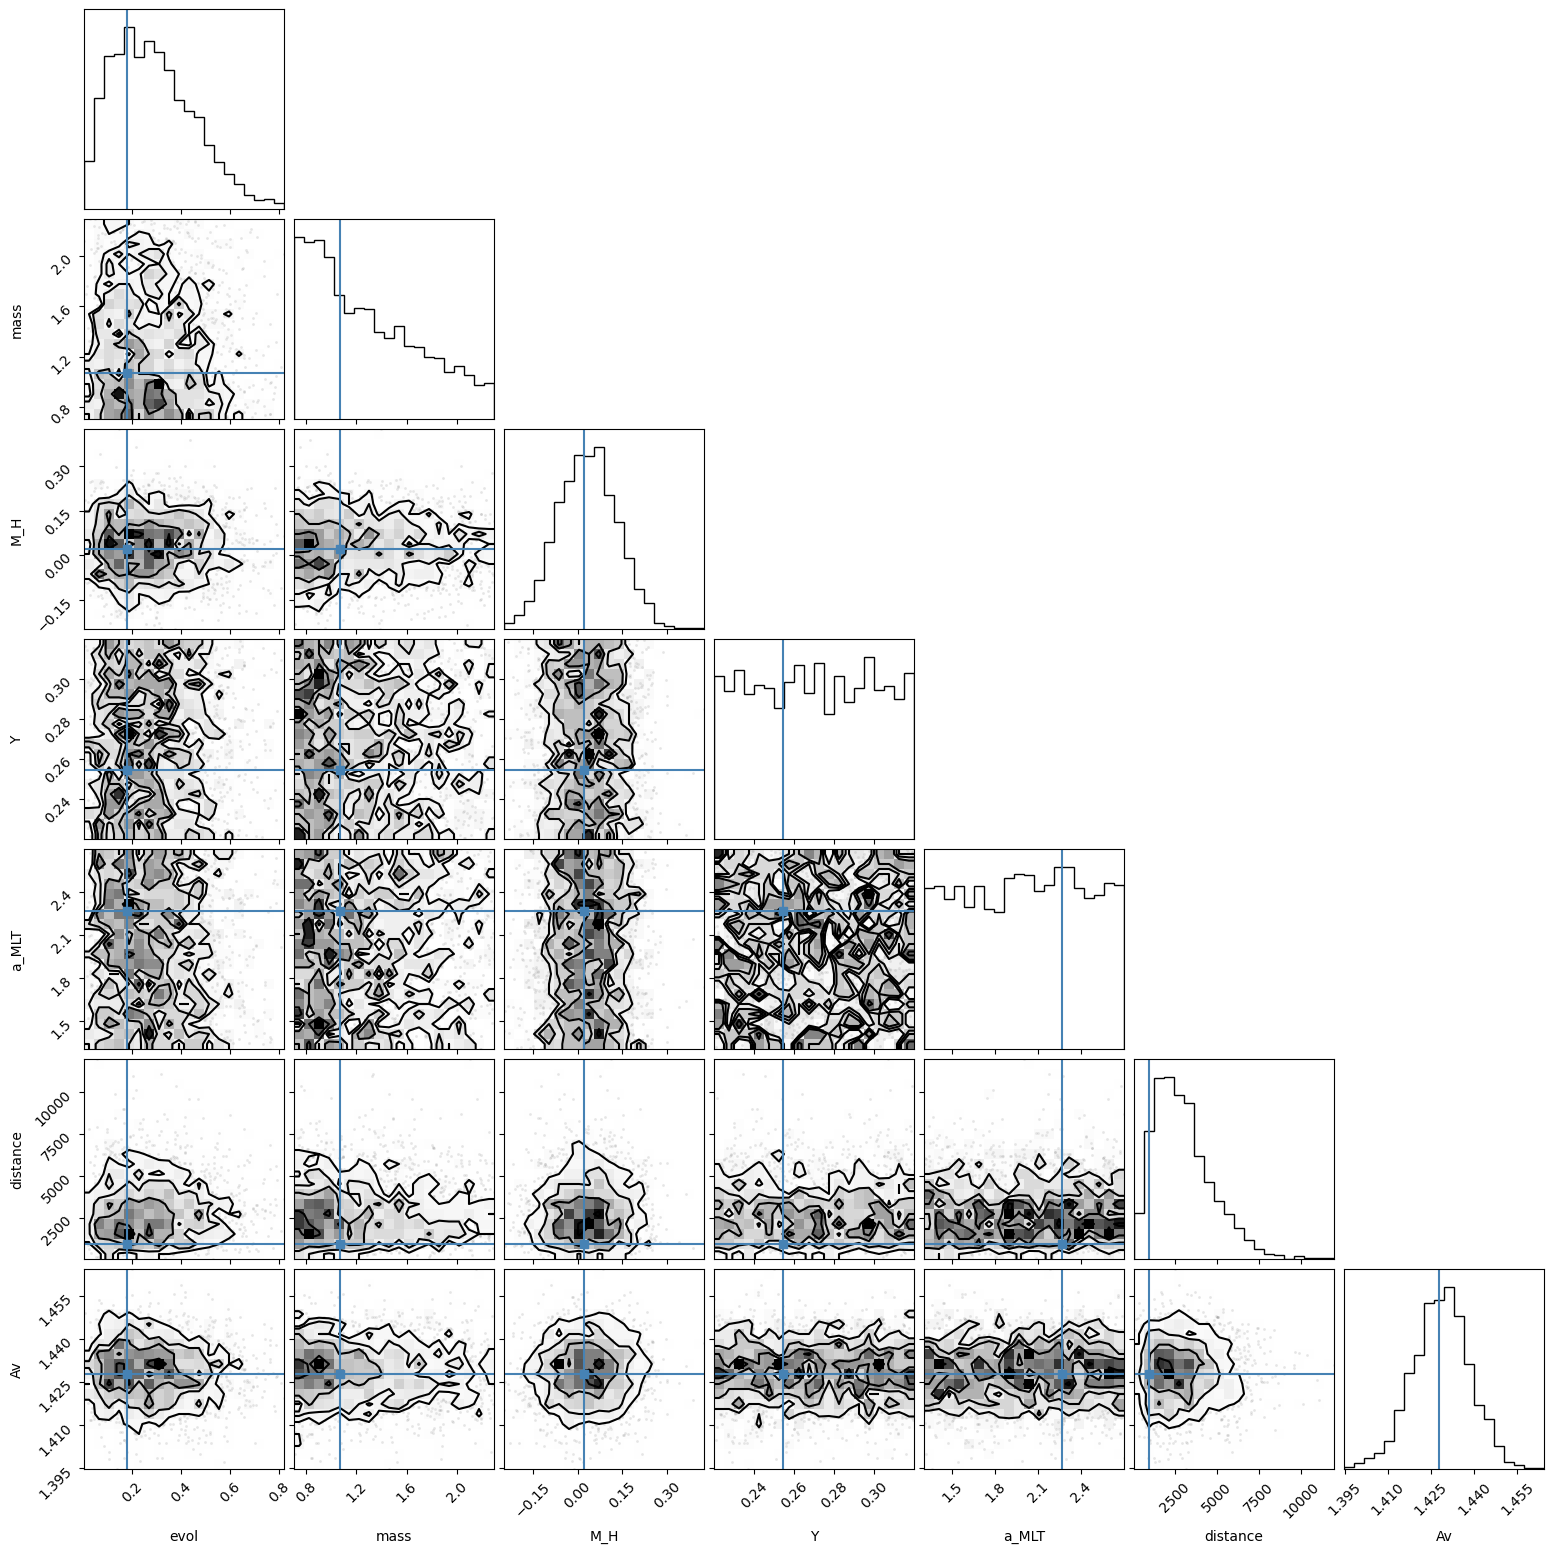

In [7]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT", "distance", "Av"]
fig = corner(data, group="prior", var_names=var_names, truths=truths)

Let's also look at some determinisitc parameters in the model.

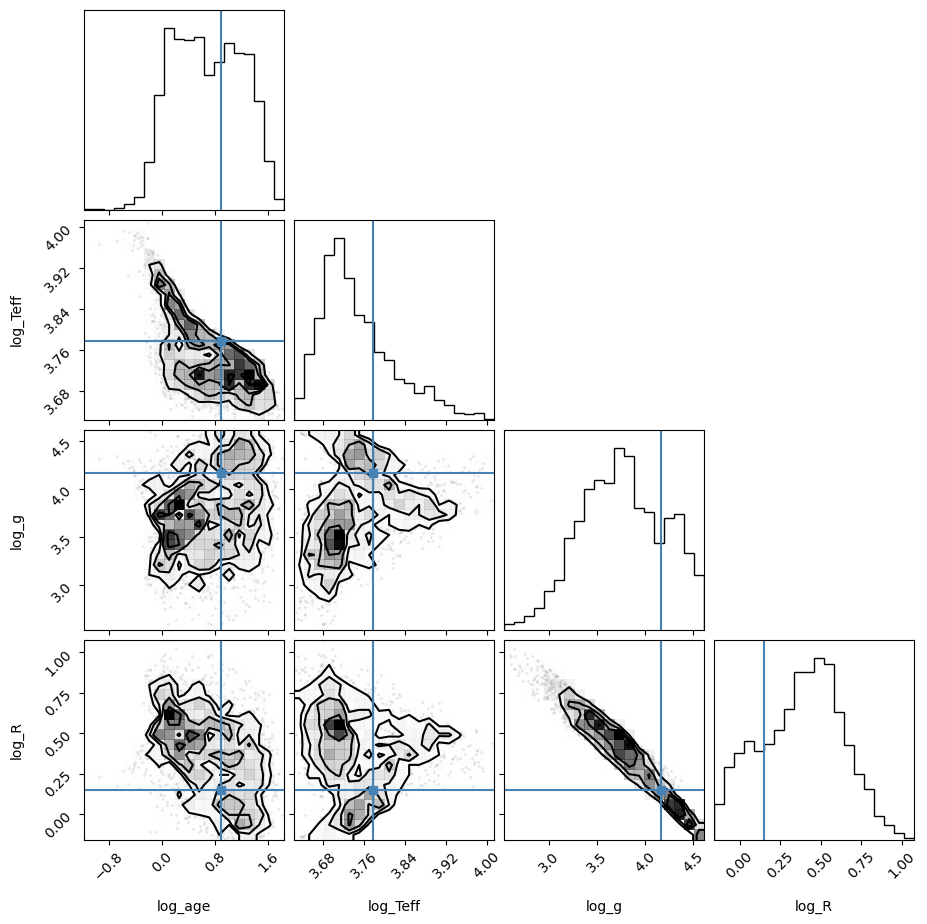

In [8]:
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
fig = corner(data, group="prior", var_names=var_names, truths=truths)

## Observation

Now we synthesize observable parameters for the model.

In [9]:
rng, *keys = random.split(rng, 3)
obs = {
    "mag": truths["mag"] + const["mag"]["scale"] * random.normal(keys[0], shape=truths["mag"].shape),
    "plx": truths["plx"] + const["plx"]["scale"] * random.normal(keys[1]),
}
pprint(obs)

{'mag': Array([15.493556  , 14.15456362, 14.87424509], dtype=float64),
 'plx': Array(0.00100286, dtype=float64)}


## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [10]:
sampler = NUTS(model)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=10)

Let's run the MCMC and print a summary of results.

In [11]:
rng, key = random.split(rng)
mcmc.run(key, obs=obs)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      1.43      0.01      1.43      1.41      1.45   6967.86      1.00
       M_H      0.04      0.10      0.04     -0.12      0.21   4571.97      1.00
         Y      0.27      0.03      0.27      0.23      0.32   4565.23      1.00
     a_MLT      1.97      0.39      1.95      1.30      2.53   4423.31      1.00
  distance    997.40     11.11    997.27    979.71   1015.52   7419.53      1.00
      evol      0.17      0.05      0.18      0.10      0.25   2578.52      1.00
  log_mass      0.03      0.03      0.03     -0.03      0.09   2847.75      1.00

Number of divergences: 0


Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

Let's update our `InferenceData`.

In [12]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [13]:
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Av,1.429,0.010,1.409,1.448,0.000,0.000,7020.0,6055.0,1.0
M_H,0.039,0.099,-0.152,0.225,0.001,0.001,4622.0,4289.0,1.0
R,1.470,0.035,1.406,1.538,0.000,0.000,7285.0,5629.0,1.0
Teff,5946.807,61.678,5832.477,6062.607,0.683,0.484,8328.0,6548.0,1.0
Y,0.270,0.029,0.226,0.319,0.000,0.000,4501.0,4519.0,1.0
a_MLT,1.970,0.388,1.304,2.597,0.006,0.004,4333.0,4347.0,1.0
abs_mag[0],5.495,0.027,5.441,5.542,0.000,0.000,7842.0,5848.0,1.0
abs_mag[1],4.155,0.026,4.105,4.204,0.000,0.000,7760.0,6080.0,1.0
abs_mag[2],4.889,0.025,4.840,4.935,0.000,0.000,7667.0,5863.0,1.0
age,6.836,1.979,3.148,10.219,0.036,0.025,3077.0,3067.0,1.0


## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

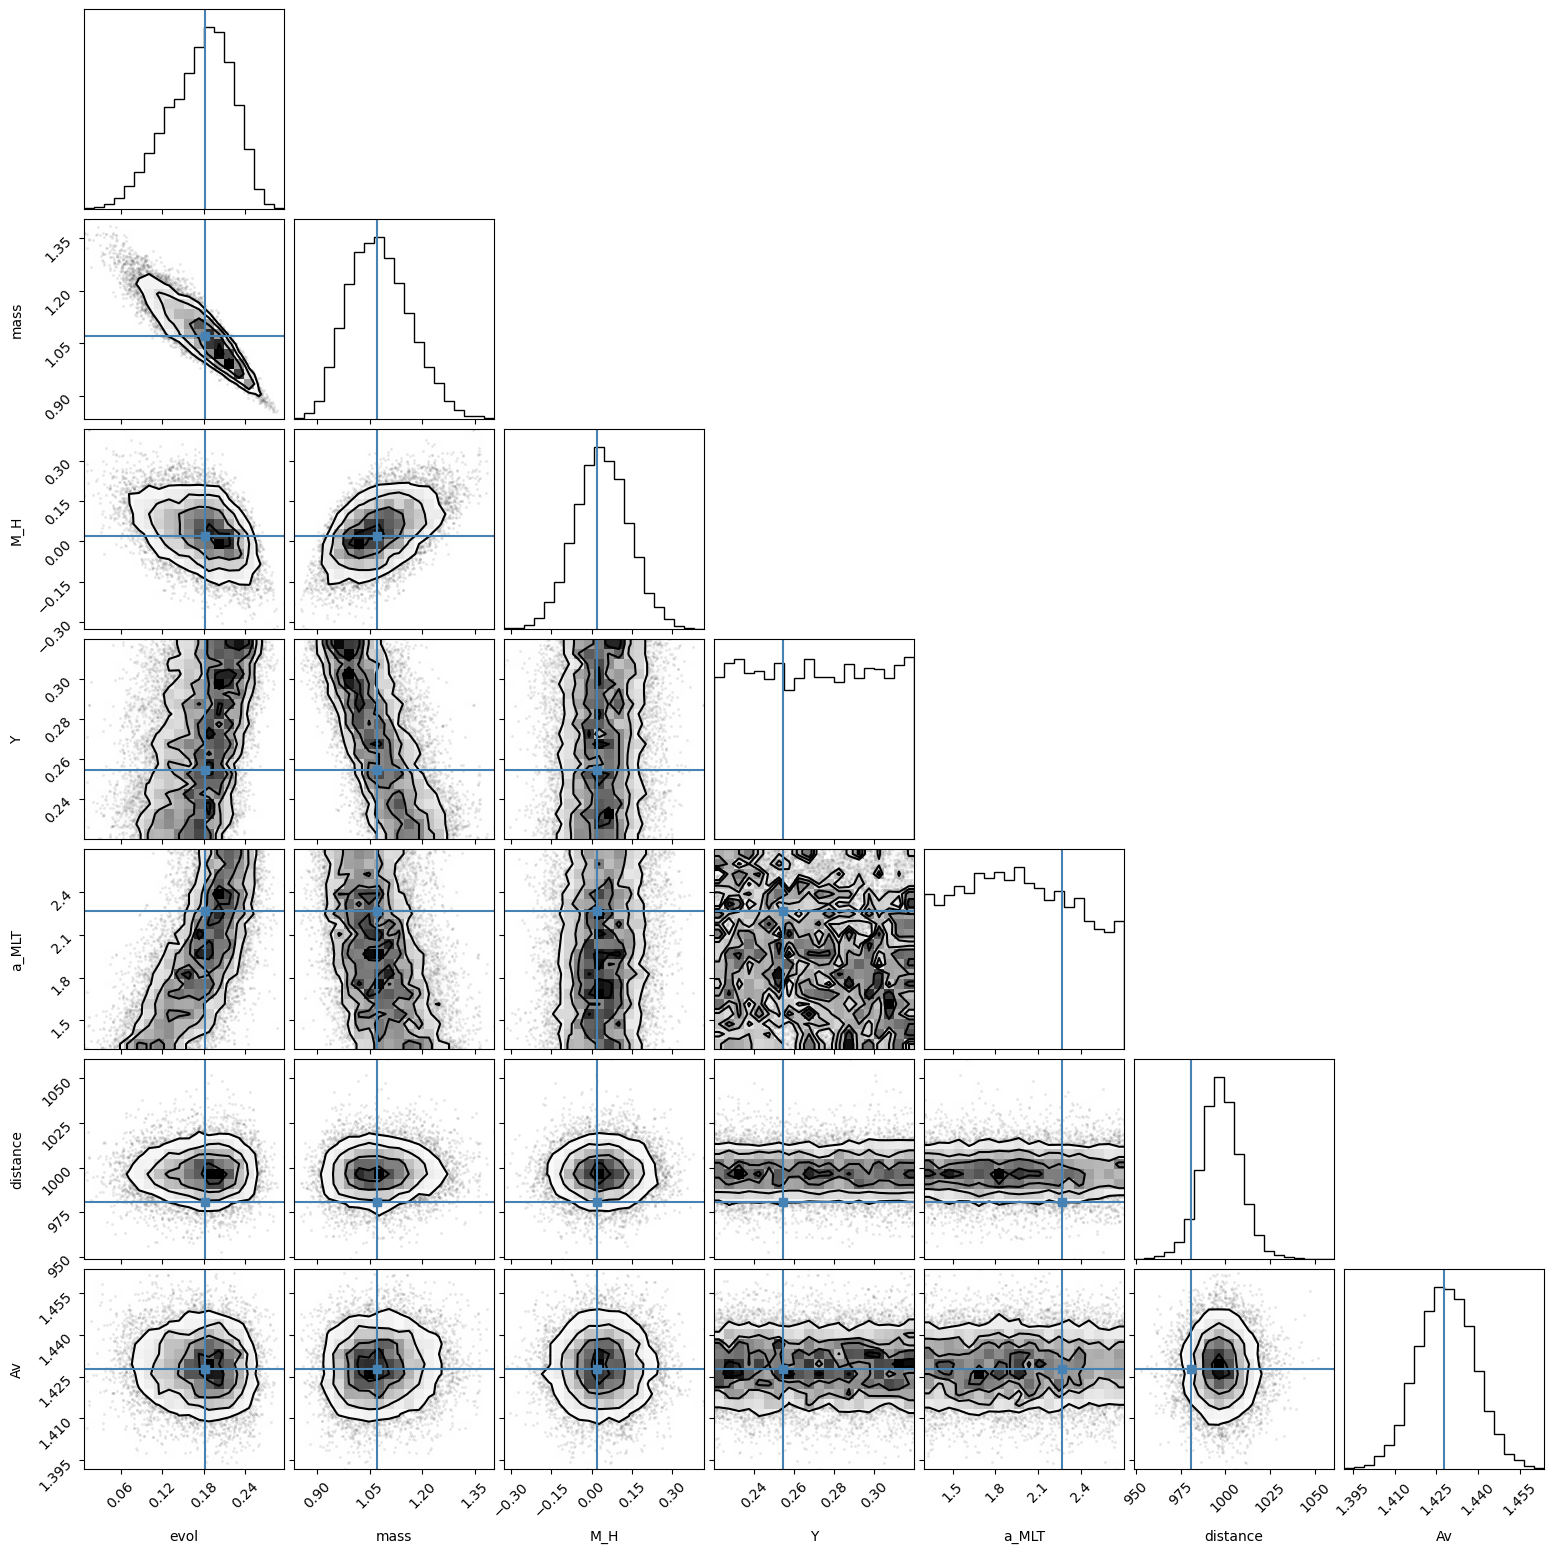

In [14]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT", "distance", "Av"]
fig = corner(data, group="posterior", var_names=var_names, truths=truths)

What do we predict for some deterministics?

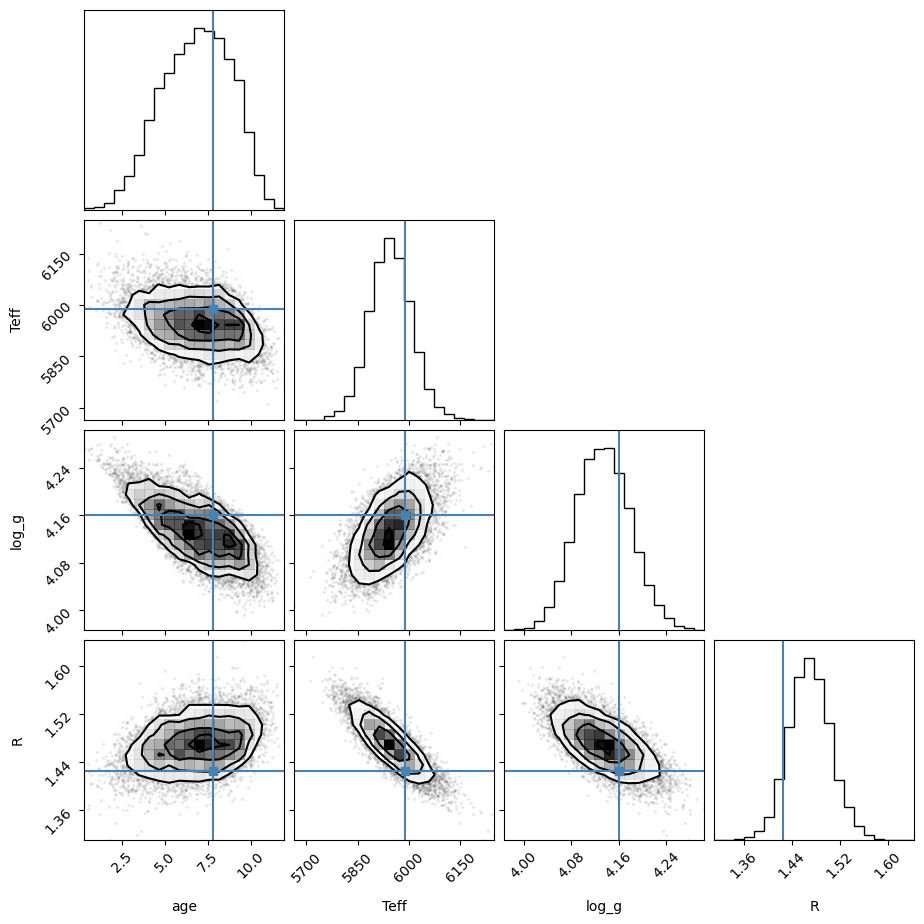

In [15]:
var_names = ["age", "Teff", "log_g", "R"]
fig = corner(data, group="posterior", var_names=var_names, truths=truths)

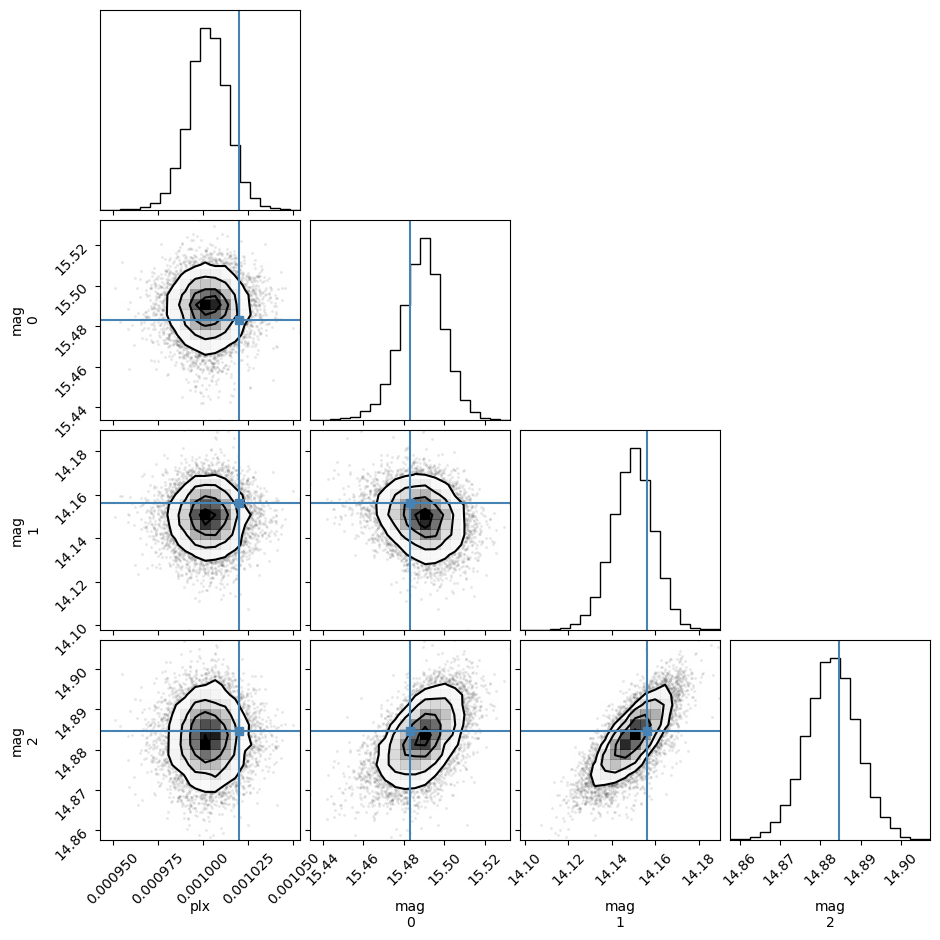

In [16]:
var_names = ["plx", "mag"]
fig = corner(data, group="posterior", var_names=var_names, truths=truths)